# Predicting Champs Scalar-Coupling

J-Coupling is observed in NMR or MRI spectra when two atoms interact together to split their chemical-magnetic structure.  While the value of this coupling can be estimated with reasonable accuracy using the quantum mechanical modeling methods, these calculations are very expensive, and sometimes, prohibitive.  In this project, we seek an alternative approach, where we use machine learning and known coupling interacts in a variety of molecules to predict this interaction.  A successful prediction could have many benifical applicaitons, including in molecular design, and chemical synthesis.

The dataset we are using comes from the CHAMPS (CHemistry and Mathematics Phase Space) dataset uploaded for a Kaggle competition in May 2019.

We will begin by reading in the data and doing some exploratory data analysis.  We have a number of potentially interesting data sets available, but we will begin by focusing on the most interesting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import networkx as nx

train = pd.read_csv('train.csv')
structures = pd.read_csv('structures.csv')
scalar_coupling = pd.read_csv('scalar_coupling_contributions.csv')
potential_energy = pd.read_csv('potential_energy.csv')
dipoles = pd.read_csv('dipole_moments.csv')
magnetic_shielding = pd.read_csv('magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('mulliken_charges.csv')
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')



Let's look at these files and see which ones will be most handy.

In [2]:
train.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [3]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [4]:
scalar_coupling.head()

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.0224,0.254579,1.25862,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.0347,0.352978,2.85839,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.0325,0.352944,2.85852,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.0319,0.352934,2.85855,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.0222,0.254585,1.25861,0.272013


In [5]:
potential_energy.head()

,molecule_name,potential_energy
0,dsgdb9nsd_000001,-40.52368
1,dsgdb9nsd_000002,-56.56025
2,dsgdb9nsd_000003,-76.42608
3,dsgdb9nsd_000005,-93.42849
4,dsgdb9nsd_000007,-79.83869


In [6]:
dipoles.head()

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0,1.6256
2,dsgdb9nsd_000003,0.0000,0.0,-1.8511
3,dsgdb9nsd_000005,0.0000,0.0,-2.8937
4,dsgdb9nsd_000007,0.0000,0.0,0.0000


In [7]:
magnetic_shielding.head()

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013


In [8]:
mulliken.head()

,molecule_name,atom_index,mulliken_charge
0,dsgdb9nsd_000001,0,-0.535689
1,dsgdb9nsd_000001,1,0.133921
2,dsgdb9nsd_000001,2,0.133922
3,dsgdb9nsd_000001,3,0.133923
4,dsgdb9nsd_000001,4,0.133923


From looking at these datasets, we the scalar coupling is done on a two atom basis; i.e. the scalar coupling magnitude from Atom_X with Atom_Y within molecule Z. We have some atom level metrics, such as the position metrics in the structures, or the magnetic shielding properties.  We also have molecular level properties, such as the dipoles, and potential energy.

This is a sophisticated chemistry and physics problem, so a bit of domain research will be helpful.  A bit of reading shows that the coupling constant will primary be based upon atom-atom proximity, and dihedral angle.  Further, the magnetic moment is frequently cited as playing a large role.  As such, we will being by focusing on the location features in structures, and the magnetic moment attirubutes.  This will also be where we will expect to generate potentially useful features.

Furthermore, we can see that there the coupling constant is dependent on the type: 1JHC has a very high coupling constant, while 2JHH, for example is quite low. We expect this to be an important feature in the model.

In [2]:
fig, ax = plt.subplots(figsize=(14,6))
plt.subplot(1,2,1)
sns.violinplot(x='type', y='scalar_coupling_constant', data=train)
plt.title('Scalar Coupling by Type')
plt.subplot(1,2,2)
sns.countplot(train['type'])
plt.title('Frequency by Type')
plt.show()

NameError: name 'plt' is not defined

First, let's go ahead and build in some geometric information, particularly distance and angle.  To do this, we will need to do some data merges.

In [10]:
train_merge_0 = train.merge(structures, how='left', left_on=['molecule_name','atom_index_0'], right_on=['molecule_name','atom_index'], suffixes = ('', '_0'))
train_merge_0.drop('atom_index', axis=1, inplace=True)
train_merge_0.rename(columns = {'atom': 'atom_0',
                               'x' : 'x_0',
                               'y' : 'y_0',
                               'z' : 'z_0'}, inplace= True)

train_struc = train_merge_0.merge(structures, how='left', left_on=['molecule_name','atom_index_1'], right_on=['molecule_name','atom_index'], suffixes = ('', '_0'))
train_struc.drop('atom_index', axis=1, inplace=True)
train_struc.rename(columns = {'atom': 'atom_1',
                               'x' : 'x_1',
                               'y' : 'y_1',
                               'z' : 'z_1'}, inplace= True)

train_struc.head()


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [11]:
ts = train_struc
train_struc['distance'] = np.sqrt((ts['x_0'] - ts['x_1'])**2 + (ts['y_0'] - ts['y_1'])**2 + (ts['z_0'] - ts['z_1'])**2)
train_struc['distance'].head()

0    1.091953
1    1.783120
2    1.783147
3    1.783157
4    1.091952
Name: distance, dtype: float64

We can calculate the dihedral angle with the formula used below.  This should vary between 0 and pi/2 radians.

In [12]:
train_struc['dihedral'] = np.arccos(np.abs(ts['x_0'] * ts['x_1'] + ts['y_0']*ts['y_1'] + ts['z_0']*ts['z_1'])/(np.sqrt(ts['x_0']**2 + ts['y_0']**2 + ts['z_0']**2)* np.sqrt(ts['x_1']**2 + ts['y_1']**2 +ts['z_1']**2)))
train_struc['dihedral'].describe()

# train_struc.reset_index().plot(x='index', y='dihedral')
# plt.show()

count    4.658147e+06
mean     8.111600e-01
std      3.994830e-01
min      0.000000e+00
25%      4.889463e-01
50%      7.809501e-01
75%      1.121528e+00
max      1.570796e+00
Name: dihedral, dtype: float64

Now, we will check our columns visually for correlations against the scalar coupling constant. We will only plot a portion of the data, just to speed things up a bit. This should be plenty sufficient to spot trends.

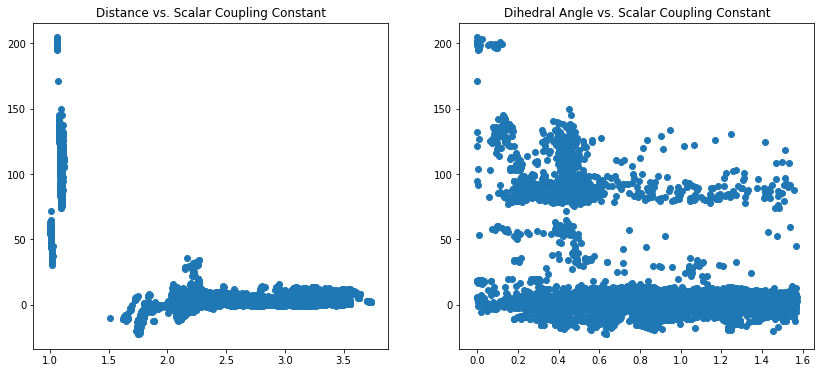

In [13]:
fig, ax = plt.subplots(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(x='distance', y='scalar_coupling_constant', data=train_struc.iloc[:10000])
plt.title('Distance vs. Scalar Coupling Constant')
plt.subplot(1,2,2)
plt.scatter(x='dihedral', y='scalar_coupling_constant', data=train_struc.iloc[:10000])
plt.title('Dihedral Angle vs. Scalar Coupling Constant')
plt.show()

We can see that there are defnitely certain trends in the data, but they the groups are clumpy, certainly not linear.  This is probably showing us that our linear regressors are not going to work well.  These features may also be highly correlated with the bond type. We will just check this now.  We also want to check if the bimodal nature of the dihedral data might be correlated with bond distance.

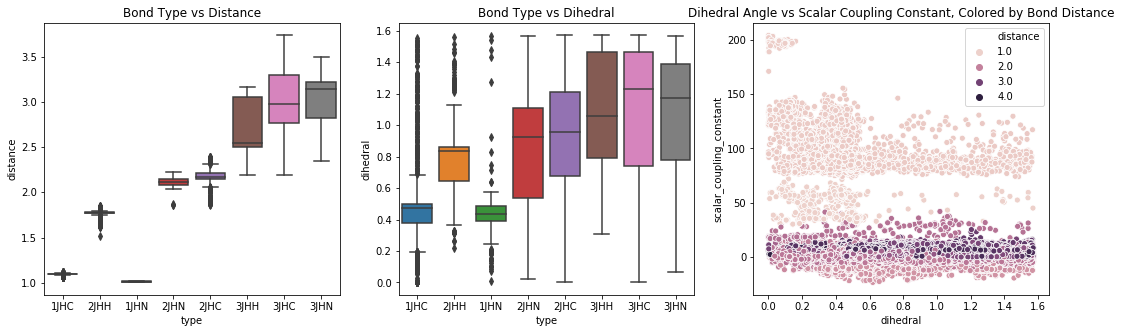

In [14]:
fig, ax = plt.subplots(figsize=(18,5))
plt.subplot(1,3,1)
sns.boxplot(x='type', y='distance', data=train_struc[:10000])
plt.title('Bond Type vs Distance')
plt.subplot(1,3,2)
sns.boxplot(x='type', y='dihedral', data=train_struc[:10000])
plt.title('Bond Type vs Dihedral')
plt.subplot(1,3,3)
sns.scatterplot(x='dihedral', y='scalar_coupling_constant', hue='distance', data=train_struc.iloc[:50000])
plt.title('Dihedral Angle vs Scalar Coupling Constant, Colored by Bond Distance')
plt.show()

Clearly the bond type plays a large role in both the distance, and the angle.  However, there is still a fair amount of spread within the major bond types on which we hope to learn.

The other data sets included all contain leakage about the scalar coupling constant; we want to be able to estimate purely from the structure.  As such, we will neglect to merge those files in for now.

Let's take a look at the dataset we have now, and see if we have any missing columns

In [15]:
train_struc.describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,distance,dihedral
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01,1.058781e-01,-2.203691e-01,4.712888e-02,9.757184e-02,-3.956294e-01,7.768257e-02,2.360922e+00,8.111600e-01
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01,1.759873e+00,2.121789e+00,1.564513e+00,1.479416e+00,1.767196e+00,1.255910e+00,7.367096e-01,3.994830e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01,-9.234889e+00,-9.494160e+00,-9.134765e+00,-9.234889e+00,-9.254405e+00,-8.789131e+00,1.002241e+00,0.000000e+00
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01,-9.530924e-01,-1.836966e+00,-9.642128e-01,-7.927602e-01,-1.607567e+00,-6.696343e-01,1.948526e+00,4.889463e-01
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00,1.341212e-01,-2.979936e-01,4.972893e-03,4.660419e-02,-5.081915e-01,1.549763e-02,2.313485e+00,7.809501e-01
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00,1.227746e+00,1.753418e+00,1.035102e+00,9.682240e-01,2.882334e-01,8.926133e-01,2.946476e+00,1.121528e+00
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02,9.382240e+00,9.714469e+00,7.637578e+00,8.420893e+00,8.653665e+00,7.460225e+00,3.924354e+00,1.570796e+00


train_struc.info()
print(train_struc.isnull().sum())

We don't have any missing data.  We have a number of int and float features now, and only a few categorical.  The atom categories are interesting, but are contained within the bond type.  As such, we will dummify the bond type to use that in the analysis. The molecule name is an interesting case, as it is likely that the scalar coupling constant between two atoms is also affected by other atoms within the same molecule.  As such, the most robust method would probably be to dummify this column as well.  However, we would soon have hundreds of thousands of columns.  For now we will assume that these do not interact to a first a order, and so will just drop the column for now.  

In [16]:
type_dummies = pd.get_dummies(train_struc['type'])
train_dummies = pd.concat([train_struc, type_dummies], axis=1)
data = train_dummies.drop(['id', 'molecule_name', 'atom_0', 'atom_1'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4658147 entries, 0 to 4658146
Data columns (total 20 columns):
atom_index_0                int64
atom_index_1                int64
type                        object
scalar_coupling_constant    float64
x_0                         float64
y_0                         float64
z_0                         float64
x_1                         float64
y_1                         float64
z_1                         float64
distance                    float64
dihedral                    float64
1JHC                        uint8
1JHN                        uint8
2JHC                        uint8
2JHH                        uint8
2JHN                        uint8
3JHC                        uint8
3JHH                        uint8
3JHN                        uint8
dtypes: float64(9), int64(2), object(1), uint8(8)
memory usage: 497.5+ MB


Now we are ready to start training models.  A bit of research into the subject, such as this [research article](https://www.nature.com/articles/s41598-018-35934-y), shows that a lot of success has been found using deep learning approaches, as that allows utilize machine learning techniques to generate useful features without extensive domain knowledge. We will also want to try a random forest estimator to see what we can learn as a point of comparison. To begin with, however, we will want to make a naive baseline model using only what we have learned without taking advantage of machine learning.  To this, we will calculate the AOC on our training set by just setting our estimate equal to the mean of the scalar coupling constant for that bond type.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [18]:
X_train = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.7)]
X_test = data.iloc[np.random.permutation(len(data))].iloc[round(len(data)*.7):]


In [19]:
def predict():
    mean_dict= {}
    predictions = []
    for i in X_train['type'].unique():
        mean_dict[i] = X_train[X_train['type'] == i]['scalar_coupling_constant'].mean()
    for index, row in X_test.iterrows():
        predictions.append(mean_dict[row['type']])
    X_test['predictions'] = predictions
    return X_test

X_prediction = predict()
X_prediction.head(10)


,atom_index_0,atom_index_1,type,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,...,dihedral,1JHC,1JHN,2JHC,2JHH,2JHN,3JHC,3JHH,3JHN,predictions
4298646,16,5,2JHC,-0.893426,-1.544862,-5.830002,0.253949,-0.159575,-4.166028,-0.046392,...,0.227017,0,0,1,0,0,0,0,0,-0.270386
2839779,12,6,3JHN,0.412699,-0.734103,-3.136899,3.013037,-1.507525,-1.337721,1.022865,...,0.571604,0,0,0,0,0,0,0,1,0.988170
3470423,11,12,3JHH,2.657160,-0.757780,1.995970,0.871087,0.459529,-0.228783,0.862712,...,1.547739,0,0,0,0,0,0,1,0,4.771326
1158410,14,6,3JHC,4.821610,-0.365873,-0.048969,2.112343,1.252031,0.040578,-0.746925,...,0.861115,0,0,0,0,0,1,0,0,3.689684
2823613,14,15,2JHH,-12.829800,0.816168,0.150457,-3.315296,1.046191,1.427523,-2.124034,...,0.538737,0,0,0,1,0,0,0,0,-10.288261
4361101,15,5,2JHC,-1.552430,-2.399458,-3.678646,1.003569,-2.133490,-3.561432,-1.230715,...,0.514225,0,0,1,0,0,0,0,0,-0.270386
1530634,17,8,2JHN,0.446570,2.039054,-0.200515,1.792544,2.360294,1.727642,1.041017,...,0.723936,0,0,0,0,1,0,0,0,3.132305
422996,10,2,3JHN,3.648770,-0.960248,1.923179,0.198939,1.374965,-0.601830,-0.038345,...,0.696939,0,0,0,0,0,0,0,1,0.988170
1406191,15,6,2JHC,-1.261980,-0.058605,5.154729,1.631935,1.057518,4.676180,-0.203407,...,0.418231,0,0,1,0,0,0,0,0,-0.270386
4140543,12,20,3JHH,1.583480,1.483441,0.142113,-1.460385,-1.049356,0.088892,-2.390308,...,1.205526,0,0,0,0,0,0,1,0,4.771326


In [20]:
score = np.log(mean_absolute_error(X_test['scalar_coupling_constant'], X_prediction['predictions']))
print(score)

1.440810789554844


Using the log on the mean absolute error we see a score of 1.44 as the baseline using just the means of for that bond type in the training set. This would put as at 2555/2749, or bottom 7th percentile on the kaggle leaderboard if it help up for the test set, or  We will start with a random forest model to see if we can improve on that.  We will make a few more geometric features just to possibly help the model.  Finally, we are also going to sample from the data so that we can find promising models more quickly.  Once we ahve an estimator we like, we can fit it to the full dataset.

In [21]:
data['x_dist'] = np.abs(data['x_1'] - data['x_0'])
data['y_dist'] = np.abs(data['y_1'] - data['y_0'])
data['z_dist'] = np.abs(data['z_1'] - data['z_0'])

data_quick = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.01)]

features_quick = data_quick.drop(['type', 'scalar_coupling_constant'], axis=1)
target_quick = data_quick['scalar_coupling_constant']
data_quick.shape

(46581, 23)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

# params = {
# n_estimators: 5,
# min_samples_leaf: 15
# }

rf = RandomForestRegressor(5, min_samples_leaf=15)
lr = LinearRegression()
rfe = RFECV(rf, cv=10)
rfe.fit(features_quick, target_quick)
predictions = rfe.predict(features_quick)



In [23]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)


0.7110044399837099


In [24]:
print(rfe.support_)

[ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True]


With a random forest model using only .1% of the data, and no hyperparameter optimization, we have improved our score to .69, which would put us in the bottom 21st percentile.  A big improvement, but there is a lot of room to go.  Let's shrink the data back down again and do a grid search on the random forest.  The feature selector used all of the features we created, which makes sense for a random_forest model.  We will use all features going forward

In [25]:
data_quick = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.001)]
features_quick = data_quick.drop(['type', 'scalar_coupling_constant'], axis=1)
target_quick = data_quick['scalar_coupling_constant']

In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [15],
    'max_depth': [None, 10000, 3000, 1000],
    'min_weight_fraction_leaf' : [0, .000001, .000001, .00001],
    'random_state': [1],
}

gs = GridSearchCV(rf, param_grid=params, cv=10)
gs.fit(features_quick, target_quick)
predictions = gs.predict(features_quick)

In [27]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

0.8875490940189555
{'max_depth': None, 'min_weight_fraction_leaf': 0, 'n_estimators': 15, 'random_state': 1}


In [28]:
params = {
    'n_estimators': [5, 15, 100, 1000],
    'max_depth': [None],
    'min_weight_fraction_leaf' : [0],
    'random_state': [1],
}

gs = GridSearchCV(rf, param_grid=params, cv=10)
gs.fit(features_quick, target_quick)
predictions = gs.predict(features_quick)

In [29]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

0.8855866233071351
{'max_depth': None, 'min_weight_fraction_leaf': 0, 'n_estimators': 100, 'random_state': 1}


In [30]:
params = {
    'n_estimators': [5, 15, 50, 150, 1000],
    'min_samples_leaf': [1,2,5,15,50,100],
    'min_weight_fraction_leaf' : [0],
    'random_state': [1],
}

gs = GridSearchCV(rf, param_grid=params, cv=10)
gs.fit(features_quick, target_quick)
predictions = gs.predict(features_quick)

In [31]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

0.14438179776335525
{'min_samples_leaf': 2, 'min_weight_fraction_leaf': 0, 'n_estimators': 1000, 'random_state': 1}


We managed to get the score down to 0.51 on the smaller dataset.  We will go ahead and run a larger chunk of the dataset to get a sense of how well we can do with the random forest without extensive domain knowledge, a deep dive on optimization, or larger computing resources.

In [32]:
data_quick = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.01)]
features_quick = data_quick.drop(['type', 'scalar_coupling_constant'], axis=1)
target_quick = data_quick['scalar_coupling_constant']

In [33]:
params = {
    'n_estimators': [150],
    'min_samples_leaf': [5],
    'min_weight_fraction_leaf' : [0],
    'random_state': [1],
}

gs = GridSearchCV(rf, param_grid=params, cv=10)
gs.fit(features_quick, target_quick)
predictions = gs.predict(features_quick)

In [34]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

0.33914995829691513
{'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0, 'n_estimators': 150, 'random_state': 1}


Through optimization, we were able to reduce our score to 0.36 (bottom 28th percentile).  This could probably be improved further by using the full data set, but we would rather not devote the computing resources to it at this time.  Let's get  visual idea of how the model is perfoming, and the move on to a deep neural network as the literature suggests.

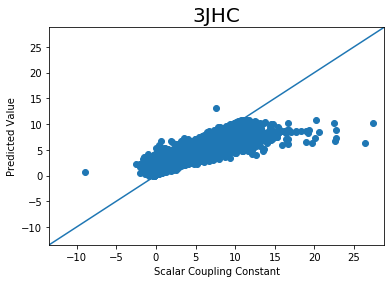

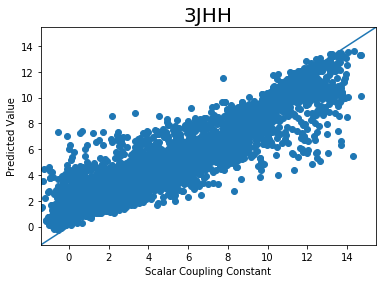

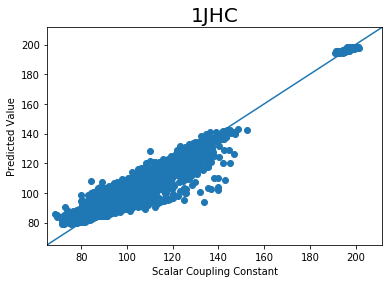

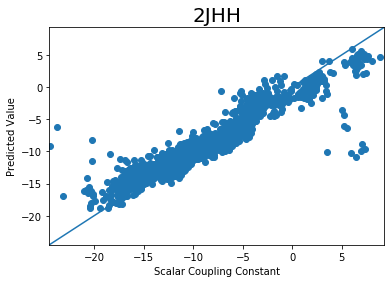

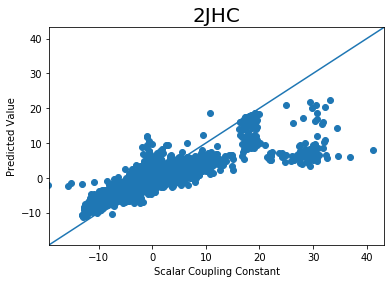

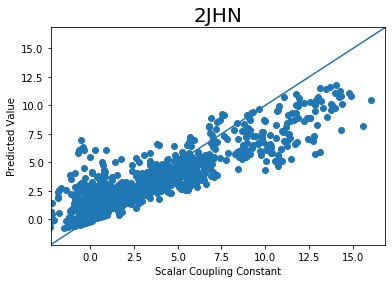

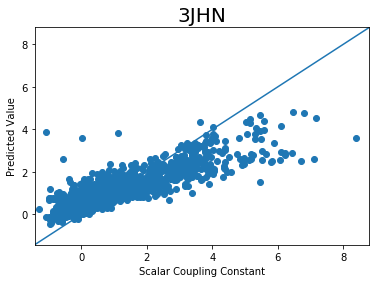

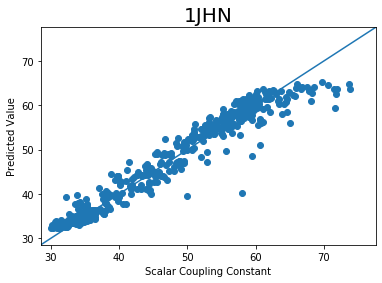

In [46]:
answers = pd.DataFrame({'Scalar Coupling Constant': target_quick, 'Predicted Value' : predictions, 'Bond Type': data_quick['type']})
def plotoof(type):
    subframe = answers[answers['Bond Type'] == type]
    x = subframe['Scalar Coupling Constant']
    y = subframe['Predicted Value']
    plt.scatter(x, y)
    llim = x.min()- x.min()*0.05
    ulim = x.max()+ x.max()*0.05
    plt.xlim(llim,ulim)
    plt.ylim(llim,ulim)
    plt.plot([llim,ulim], [llim, ulim])
    plt.xlabel('Scalar Coupling Constant')
    plt.ylabel('Predicted Value')
    plt.title(f'{type}', fontsize=20)
    plt.show()
    
type_list = answers['Bond Type'].unique()    
for i in type_list:
    plotoof(i)

In [53]:
def score_by_type(type):
    subframe = answers[answers['Bond Type'] == type]
    x = subframe['Scalar Coupling Constant']
    y = subframe['Predicted Value']
    score = np.log(mean_absolute_error(x, y))
    print('log MAE', type + ':' , score)
for i in type_list:
    score_by_type(i)

log MAE 3JHC: 0.0926558576999431
log MAE 3JHH: -0.01596183998856257
log MAE 1JHC: 1.05279613869777
log MAE 2JHH: -0.2446135760480103
log MAE 2JHC: 0.36929728218731495
log MAE 2JHN: 0.30305188087114066
log MAE 3JHN: -0.6495431524295435
log MAE 1JHN: 0.6530853911978208


In [127]:
data_quick = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.001)]
features_quick = data_quick.drop(['type', 'scalar_coupling_constant'], axis=1)
target_quick = data_quick['scalar_coupling_constant']

In [132]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()

params = {
    'hidden_layer_sizes': [(4,4), (5,5)],
    'activation': ['relu'],
    'solver' : ['sgd'],
    'learning_rate' : ['constant'],
    'max_iter': [300000],
    'random_state': [1],
}

gs = GridSearchCV(mlp, param_grid=params, scoring='neg_mean_absolute_error', cv=10)
gs.fit(features_quick, target_quick)
predictions = gs.predict(features_quick)

In [133]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

3.1944230487560143
{'activation': 'relu', 'hidden_layer_sizes': (4, 4), 'learning_rate': 'constant', 'max_iter': 300000, 'random_state': 1, 'solver': 'sgd'}


We can see from the plots that our predictions are mostly trending correlating pretty well, but it is highly dependent on the bond type.  We do very well for 3JHN, for example, but compatitively poorly for 1JHC.

Before we finish off with the random forest models, we would like to give gradient boosting a try.  We will use the LGB model, which can be found [here](https://lightgbm.readthedocs.io/en/latest/index.html)

In [ ]:
score = np.log(mean_absolute_error(target_quick, predictions))
print(score)
print(gs.best_params_)

In [57]:
# import lightgbm as lgb

In [77]:
# data_quick = data.iloc[np.random.permutation(len(data))].iloc[:round(len(data)*.01)]
# features_quick = data_quick.drop(['type', 'scalar_coupling_constant'], axis=1)
# target_quick = data_quick['scalar_coupling_constant']

# lg_train = lgb.Dataset(features_quick, label=target_quick, feature_name=list(features_quick.columns))
# v_data = lg_train.create_valid('v_data.svm')

# params = {}
# params['learning_rate'] = 0.0003
# params['boosting_type'] = 'gbdt'
# params['objective'] = 'regression'
# params['metric'] = 'mae'
# params['min_data_in_leaf'] = 5
# params['max_depth'] = 200

# clf = lgb.train(params, lg_train, 100)

# # clf = lgb.cv(params, lg_train, 100, nfold=10)
# # predictions = clf.predict(features_quick, num_iteration=best_iteration)


In [78]:
# predictions = clf.predict(features_quick)

In [79]:
# score = np.log(mean_absolute_error(target_quick, predictions))
# print(score)


3.1709741532462714


In [81]:
# answers = pd.DataFrame({'Scalar Coupling Constant': target_quick, 'Predicted Value' : predictions, 'Bond Type': data_quick['type']})
# answers

,Scalar Coupling Constant,Predicted Value,Bond Type
1176811,-0.348571,15.264808,2JHC
2074859,106.729000,18.614106,1JHC
4605398,6.969250,15.264808,2JHC
588599,3.374170,15.426002,3JHH
2136041,-0.542757,15.382830,2JHC
4487208,-11.248200,14.968200,2JHH
1659929,-3.982880,15.264808,2JHC
4633848,1.637850,15.354684,3JHN
2932802,5.014520,15.411350,2JHN
1109413,5.148120,15.426002,3JHH


In [37]:
# mag_merge = atom_merge(train_struc, magnetic_shielding, ['XX', 'YX', 'ZX', 'XY', 'YY', 'ZY', 'XZ', 'YZ', 'ZZ'] )
# mul_merge = atom_merge(mag_merge, mulliken, ['mulliken_charge'])
# pe_merge = mol_merge(mul_merge, potential_energy)
# dp_merge = mol_merge(pe_merge, dipoles, ['X', 'Y', 'Z'], label='_dipole')
# train_merge = atom_pair_merge(dp_merge,scalar_coupling)
# train_merge.head(10)

Now let's describe the full data set we have a little more, and look for any missing values.

In [38]:
# train_merge.info()
# print(train_merge.isnull().sum())

In [39]:
# train_merge.describe()

So, we are glad to see that we don't have any missing values in any of the data, and nearly all of our data is in floats, ready to be used for machine learning.

We have a few columns which are categorical or string type. The molecule name we won't bother doing anything with, it is a labeller that won't be used for training.  The atom types are contained within the bond type, so we won't use those either.  However, we have seen that the bond type is very important for the scalar coupling constant, so we will go ahead and dummify that column.

In [40]:
# bond_cols = pd.get_dummies(train_merge['type'])
# train_dummies = pd.concat([train_merge, bond_cols], axis=1)
# train_dummies.head(10)

Now that we have all of these other columns. We want to do a little research to see if there is further engineering that can be done.

One obvious place to start is to try a dipole magnitude feature.  

In [41]:
# tm = train_merge
# train_merge['dipole_mag'] = np.sqrt(tm['X_dipole']**2 + tm['Y_dipole']**2 + tm['Z_dipole']**2)
# train_merge['dipole_mag'].head(20)

Now we are ready to start training some models.  We will begin by dropping the columns we know we won't use for training

In [42]:
# train.shape